In [119]:
%reload_ext autoreload
%autoreload 2
%run registration.py 
%run classifier.py 
%run dataset.py 

Main function.


In [1]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from registration import *
from classifier import Classifier
from dataset import NiftiImage
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop, RandomCrop, Resize, RandomHorizontalFlip, Compose
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Project 2: Segmentation and analysis of pelvic bone in CT images

## task 1-3: Registration and atlas-based segmentaion

In [6]:
image_view = False
fix_img_indexes = [40,41,42]
for i in fix_img_indexes:
    # load fix images and masks
    fix_img_filepath = './data/Resized/COMMON/common_{0}_image.nii.gz'.format(i)
    fix_mask_filepath = './data/Resized/COMMON/common_{0}_mask_2c.nii.gz'.format(i)
    fix_img = sitk.ReadImage(fix_img_filepath, sitk.sitkFloat32)
    fix_mask = sitk.ReadImage(fix_mask_filepath)

    mov_img_indexes = [74,75,76]
    atlas_ct_list = []
    atlas_seg_list = []
    for j in mov_img_indexes:
        # load moving images and masks
        mov_img_filepath = './data/Resized/GROUP8/g8_{0}_image.nii.gz'.format(j)
        mov_mask_filepath = './data/Resized/GROUP8/g8_{0}_mask_2c.nii.gz'.format(j)
        mov_img = sitk.ReadImage(mov_img_filepath, sitk.sitkFloat32)
        mov_mask = sitk.ReadImage(mov_mask_filepath)

        # do affine registration
        lin_transf = est_lin_transf(fix_img, mov_img, fix_mask, print_log=True)
        aligned_image = apply_lin_transf(fix_img, mov_img, lin_transf, is_label=False)
        aligned_mask = apply_lin_transf(fix_img, mov_mask, lin_transf, is_label=True)
        atlas_ct_list.append(aligned_image)
        atlas_seg_list.append(sitk.Cast(aligned_mask,sitk.sitkUInt8))

        if image_view:
            image_viewer = sitk.ImageViewer()
            image_viewer.SetApplication('/usr/bin/itksnap')
            image_viewer.Execute(fix_img)
            image_viewer.Execute(mov_img)
            image_viewer.Execute(aligned_image)
            image_viewer.Execute(fix_mask)
            image_viewer.Execute(mov_mask)
            image_viewer.Execute(aligned_mask)

    # do atlas_based seg
    est_fix_mask = seg_atlas(atlas_seg_list,image_view)
    # save image
    est_fix_mask_filepath = './data/Resized/COMMON/common_{0}_est_mask_2c.nii.gz'.format(i)
    sitk.WriteImage(est_fix_mask, est_fix_mask_filepath)

--------
Affine registration:
Final metric value: 126081.29358596446
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 22.
Number of iterations: 22
--------
--------
Affine registration:
Final metric value: 86689.17652480745
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
Number of iterations: 100
--------
--------
Affine registration:
Final metric value: 120163.66181119488
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 26.
Number of iterations: 26
--------
--------
Affine registration:
Final metric value: 185289.8517741664
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 11.
Number of iterations: 11
--------
--------
Affine registration:
Final metric value: 157560.0304709203
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iter

## task 4: calculate hausdoff and dice coefficient

In [2]:
def computeQualityMeasures(lP,lT):
    quality=dict()
    lP = sitk.GetImageFromArray(lP)
    lT = sitk.GetImageFromArray(lT)
    labelPred=lP
    labelTrue=lT
    hausdorffcomputer=sitk.HausdorffDistanceImageFilter()
    hausdorffcomputer.Execute(labelTrue>0.5,labelPred>0.5)
    quality["avgHausdorff"]=hausdorffcomputer.GetAverageHausdorffDistance()
    quality["Hausdorff"]=hausdorffcomputer.GetHausdorffDistance()
    dicecomputer=sitk.LabelOverlapMeasuresImageFilter()
    dicecomputer.Execute(labelTrue>0.5,labelPred>0.5)
    quality["dice"]=dicecomputer.GetDiceCoefficient()
    return quality



In [12]:
fix_mask_index = [40,41,42]
task1 = './data/COMMON_images_masks'
task3 = './data/Resized/COMMON'
task3_est = './data/outputs'
for i in fix_mask_index:
    gt_fix_mask_filepath =  os.path.join(task3,'common_{0}_mask_2c_gt.nii.gz'.format(i))
    est_fix_mask_filepath = os.path.join(task3_est,'common_{0}_est_mask_2c.nii.gz'.format(i))
    gt_fix_mask = sitk.ReadImage(gt_fix_mask_filepath)
    est_fix_mask =sitk.ReadImage(est_fix_mask_filepath)
    #gt_fix_mask = sitk.Cast(gt_fix_mask,sitk.sitkUInt16)
    #est_fix_mask = sitk.Cast(est_fix_mask,sitk.sitkUInt16)
    gt_fix_mask = sitk.GetArrayFromImage(gt_fix_mask)
    est_fix_mask = sitk.GetArrayFromImage(est_fix_mask)
    #####separate the bones#####
    gt_fix_mask_femur = np.copy(gt_fix_mask)
    gt_fix_mask_femur[gt_fix_mask_femur != 1] =0
    gt_fix_mask_hip = np.copy(gt_fix_mask)
    gt_fix_mask_hip[gt_fix_mask_hip != 3] =0
    est_fix_mask_femur = np.copy(est_fix_mask)
    est_fix_mask_femur[est_fix_mask_femur != 1] =0
    est_fix_mask_hip = np.copy(est_fix_mask)
    est_fix_mask_hip[est_fix_mask_hip != 3] =0
    print(f'---------Coefficient for right femur bone in common {i}-----------')
    quality1 = computeQualityMeasures(gt_fix_mask_femur,est_fix_mask_femur)
    print(quality1)
    print(f'---------Coefficient for right hip bone in common {i}-----------')
    quality2 = computeQualityMeasures(gt_fix_mask_hip,est_fix_mask_hip)
    print(quality2)

---------Coefficient for right femur bone in common 40-----------
{'avgHausdorff': 3.3781686481514974, 'Hausdorff': 30.066592756745816, 'dice': 0.597274737098713}
---------Coefficient for right hip bone in common 40-----------
{'avgHausdorff': 8.50505689213895, 'Hausdorff': 50.84289527554464, 'dice': 0.3440696202403723}
---------Coefficient for right femur bone in common 41-----------
{'avgHausdorff': 4.5019923641161945, 'Hausdorff': 37.17526059088221, 'dice': 0.5312757818196346}
---------Coefficient for right hip bone in common 41-----------
{'avgHausdorff': 9.656494021899668, 'Hausdorff': 54.26785420486054, 'dice': 0.3010262722358213}
---------Coefficient for right femur bone in common 42-----------
{'avgHausdorff': 4.305137342116171, 'Hausdorff': 32.155870381627054, 'dice': 0.5480250929746513}
---------Coefficient for right hip bone in common 42-----------
{'avgHausdorff': 9.320596968467004, 'Hausdorff': 51.66236541235796, 'dice': 0.31156886792952465}


## task5: classifier

### method 1: using convolution network

In [120]:
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 0}
max_epoch = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using {device} device")
writer1 = SummaryWriter('runs/exp1')
img_dir = r'.\data\Resized\COMMON'
y1 = np.zeros((1,205))
y1[:,17:39]=1
y2 = np.zeros((1,205))
y2[:,51:76]=1
y3 = np.zeros((1,205))
y3[:,83:101]=1
y = np.concatenate((y1.T,y2.T),axis=0)
labels = np.concatenate((y,y3.T),axis=0)
transformations = transforms.Compose([transforms.CenterCrop(100)])
training_set = NiftiImage(labels,img_dir,transformations)
net = Classifier(layers=3,base_nc=16)
if torch.cuda.is_available(): #weights of network on gpu
    net.cuda()
training_generator = DataLoader(training_set, **params)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for i in range(max_epoch):
    running_loss = 0.0
    for i,data in enumerate(training_generator,0):
        local_batch,local_labels = data
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        optimizer.zero_grad()
        outputs = net(local_batch)
        loss = criterion(outputs,local_labels)
        loss.backward()
        optimizer.step()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
print('Finished Training')

using cuda device


RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

### method 2: using SVM

In [50]:

def train_classifier(im_list,label_list,cv=5,kernel='rbf'):
    '''
    Receive a list of images `im_list` and a list of vectors (one per image) with the labels 0 or 1 depending on the sagittal 2D slice contains 
    or not the pubic symphysis. Returns the trained classifier.
    '''
    slice_num=0
    for i in range(len(im_list)):
        slice_num+=im_list[i].shape[0]
    X = np.zeros((slice_num,140*80))
    slice_counter = 0
    for i in range(len(im_list)):
        for j in range(im_list[i].shape[0]):
            if i == 0:
                X[slice_counter,:]=np.ndarray.flatten(im_list[i][j,207:207+80,170:170+140])
            elif i == 1:
                X[slice_counter,:]=np.ndarray.flatten(im_list[i][j,183:183+80,173:173+140])
            elif i == 2:
                X[slice_counter,:]=np.ndarray.flatten(im_list[i][j,183:183+80,180:180+140])
            slice_counter += 1
    Y = np.ravel(label_list.T)
    model = SVC(probability=True,kernel=kernel,random_state=615)
    scores = cross_val_score(model,X,Y,cv=cv)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    model.fit(X,Y)
    return model

def pubic_symphysis_selection(im, model,index):
    """
    Receive a CT image and the trained classifier. Returns the
    axial slice number with the maximum probability of containing the
    pubic symphysis.
    """
    X = np.zeros((im.shape[0],140*80))
    for i in range(im.shape[0]):
        if index == 0:
            X[i,:]=np.ndarray.flatten(im[i,160:160+80,170:170+140])
        elif index == 1:
            X[i,:]=np.ndarray.flatten(im[i,145:145+80,180:180+140])
        elif index == 2:
            X[i,:]=np.ndarray.flatten(im[i,140:140+80,170:170+140])        
    pred = model.predict_proba(X)
    return pred
    
    



0.94 accuracy with a standard deviation of 0.02


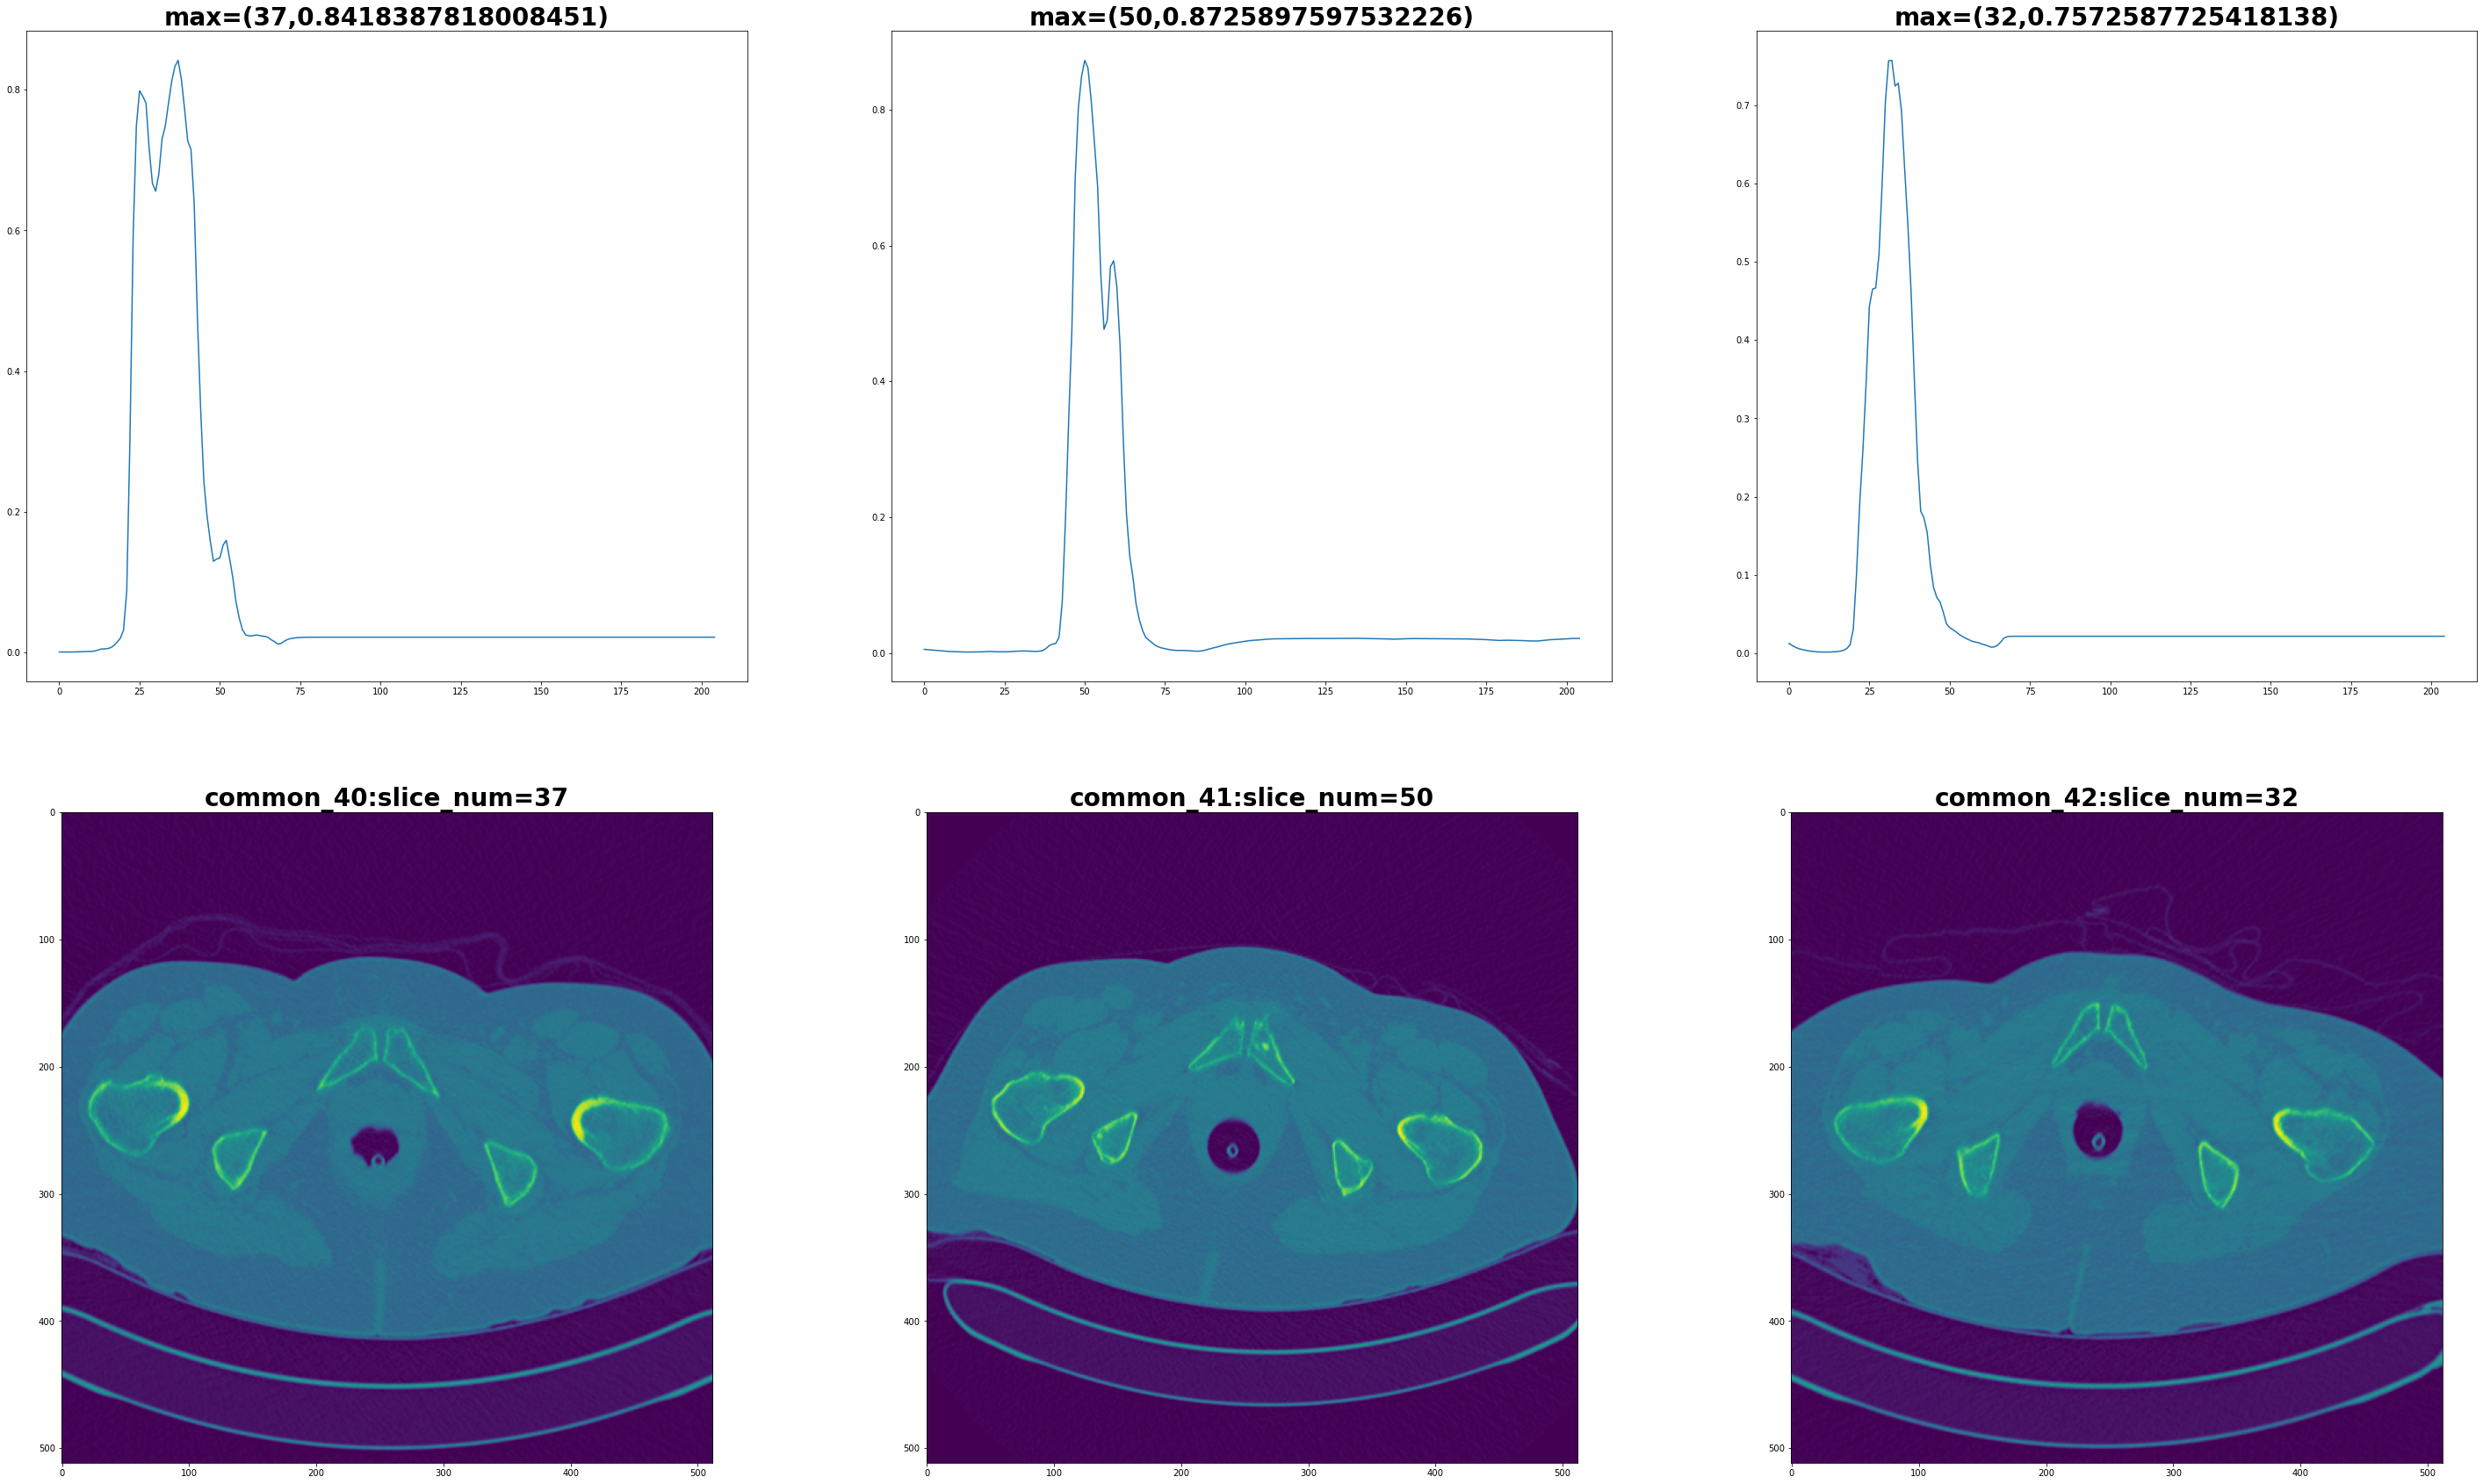

<Figure size 432x288 with 0 Axes>

In [49]:
img_dir = './data/Resized/GROUP8/'
img_file_dirs = [os.path.join(img_dir,f'g8_{i}_image.nii.gz') for i in [74,75,76]]
im_list = [sitk.GetArrayFromImage(sitk.ReadImage(img_file_dir)) for img_file_dir in img_file_dirs]
y1 = np.zeros((1,205))
y1[:,17:39]=1
y2 = np.zeros((1,205))
y2[:,51:76]=1
y3 = np.zeros((1,205))
y3[:,83:101]=1
y = np.concatenate((y1.T,y2.T),axis=0)
labels = np.concatenate((y,y3.T),axis=0)
SVM_kernel = 'rbf' #default:'rbf'
model = train_classifier(im_list=im_list,label_list=labels,kernel=SVM_kernel)

img_pred_dir = './data/Resized/COMMON/'
img_pred_file_dirs = [os.path.join(img_pred_dir,f'common_{i}_image.nii.gz') for i in [40,41,42]]
im_pred_list = [sitk.GetArrayFromImage(sitk.ReadImage(img_pred_file_dir)) for img_pred_file_dir in img_pred_file_dirs]
pred0 = pubic_symphysis_selection(im_pred_list[0],model=model,index=0)
pred1 = pubic_symphysis_selection(im_pred_list[1],model=model,index=1)
pred2 = pubic_symphysis_selection(im_pred_list[2],model=model,index=2)
pred0_loc = np.where(pred0[:,1] == max(pred0[:,1]))[0].item()
pred1_loc = np.where(pred1[:,1] == max(pred1[:,1]))[0].item()
pred2_loc = np.where(pred2[:,1] == max(pred2[:,1]))[0].item()

#plot:
plt.figure(1,figsize=(50,30))
ax1 = plt.subplot(2,3,1)
plt.plot(pred0[:,1])
plt.title(f"max=({pred0_loc},{max(pred0[:,1])})",fontsize=28,fontweight='bold')
ax2 = plt.subplot(2,3,2)
plt.plot(pred1[:,1])
plt.title(f"max=({pred1_loc},{max(pred1[:,1])})",fontsize=28,fontweight='bold')
ax3 = plt.subplot(2,3,3)
plt.plot(pred2[:,1])
plt.title(f"max=({pred2_loc},{max(pred2[:,1])})",fontsize=28,fontweight='bold')
ax4 = plt.subplot(2,3,4)
plt.imshow(im_pred_list[0][pred0_loc])
plt.title(f"common_40:slice_num={pred0_loc}",fontsize=28,fontweight='bold')
ax5 = plt.subplot(2,3,5)
plt.imshow(im_pred_list[1][pred1_loc])
plt.title(f"common_41:slice_num={pred1_loc}",fontsize=28,fontweight='bold')
ax6 = plt.subplot(2,3,6)
plt.imshow(im_pred_list[2][pred2_loc])
plt.title(f"common_42:slice_num={pred2_loc}",fontsize=28,fontweight='bold')
plt.show()
plt.close()
plt.savefig('./public_symphysis_detection.png')


